Data Preparation

In [1]:

import pandas as pd

# --------------------------
# Step 1: Load dataset
# --------------------------
df = pd.read_csv("data/openpowerlifting.csv")
print("Original dataset shape:", df.shape)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# --------------------------
# Step 2: Filter only 2019 data
# --------------------------
df_2019 = df[df['Date'].dt.year == 2019]
print("Filtered 2019 dataset shape:", df_2019.shape)

# --------------------------
# Step 3: Select relevant columns for ARM
# --------------------------
cols = [
    'Sex',
    'AgeClass',
    'WeightClassKg',
    'Equipment',
    'Best3SquatKg',
    'Best3BenchKg',
    'Best3DeadliftKg',
    'IPFPoints'
]

df_2019 = df_2019[cols]

# --------------------------
# Step 4: Convert numeric columns
# --------------------------
numeric_cols = ['WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'IPFPoints']
for col in numeric_cols:
    df_2019[col] = pd.to_numeric(df_2019[col], errors='coerce')

# Drop rows with missing WeightClassKg or IPFPoints
df_2019 = df_2019.dropna(subset=['WeightClassKg', 'IPFPoints'])
print("After cleaning:", df_2019.shape)

# --------------------------
# Step 5: Bin WeightClassKg only (categorical for ARM)
# --------------------------
weight_bins = [0, 60, 75, 90, 105, 120, 200]
weight_labels = ['<60', '60–75', '75–90', '90–105', '105–120', '120+']
df_2019['weight_bin'] = pd.cut(df_2019['WeightClassKg'], bins=weight_bins, labels=weight_labels)

# --------------------------
# Step 6: Create transactions
# --------------------------
transactions_2019 = df_2019[['Sex', 'AgeClass', 'Equipment', 'weight_bin']].astype(str)
transactions_list = transactions_2019.values.tolist()

# --------------------------
# Step 7: Save filtered dataset
# --------------------------
df_2019.to_csv("data/openpowerlifting_2019.csv", index=False)
print("Filtered 2019 dataset saved as 'openpowerlifting_2019.csv'")

transactions_2019.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_13884\109117025.py:6: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/openpowerlifting.csv")


Original dataset shape: (1423354, 37)
Filtered 2019 dataset shape: (85798, 37)
After cleaning: (70987, 8)
Filtered 2019 dataset saved as 'openpowerlifting_2019.csv'


,Sex,AgeClass,Equipment,weight_bin
690,F,24-34,Wraps,60–75
691,F,20-23,Wraps,75–90
693,F,35-39,Wraps,60–75
694,F,24-34,Raw,75–90
695,F,40-44,Wraps,60–75


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Step 8: One-hot encoding for FP-Growth
# --------------------------
te = TransactionEncoder()
te_array = te.fit(transactions_list).transform(transactions_list)
encoded_df = pd.DataFrame(te_array, columns=te.columns_)

print("One-hot encoded shape:", encoded_df.shape)
encoded_df.head()

# --------------------------
# Step 9: FP-Growth - Find frequent itemsets
# --------------------------
frequent_itemsets = fpgrowth(encoded_df, min_support=0.02, use_colnames=True)
print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
frequent_itemsets.head()

# --------------------------
# Step 10: Generate association rules
# --------------------------
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
rules = rules[rules['confidence'] >= 0.6].sort_values(by='lift', ascending=False)

# Show top 25 rules
print("Top 25 association rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(25))


One-hot encoded shape: (70987, 29)
Number of frequent itemsets: 116
Top 10 association rules:
            antecedents      consequents   support  confidence      lift
72      (24-34, 90–105)         (M, Raw)  0.020130    0.781301  3.920978
43       (24-34, 60–75)            (Raw)  0.024610    0.822505  2.725315
38           (24-34, F)            (Raw)  0.029357    0.794207  2.631553
100          (M, 20-23)            (Raw)  0.038204    0.793446  2.629032
62      (24-34, 90–105)            (Raw)  0.020356    0.790049  2.617776
69   (24-34, 90–105, M)            (Raw)  0.020130    0.789067  2.614520
98              (20-23)            (Raw)  0.052517    0.786000  2.604360
157  (120+, Single-ply)         (M, nan)  0.032964    0.959410  2.580931
156         (120+, nan)  (M, Single-ply)  0.032964    0.933759  2.566192
46       (24-34, 75–90)            (Raw)  0.021117    0.766360  2.539283


Dataset: 70,987 transactions (athlete records after one-hot encoding)

Features: 29 categorical variables (age groups, weight bins, sex, equipment, etc.)

Frequent itemsets: 116 sets met the minimum support threshold

Top Insights from the Association Rules:

Age and weight class strongly predict equipment use:

Lifters aged 24–34 in the 90–105 kg class often compete Raw (no supportive equipment).

Younger lifters (20–23) also have a high likelihood of using Raw.

Gender patterns:

Male lifters in certain age/weight groups are strongly associated with Raw or Single-ply equipment.

Female lifters aged 24–34 also tend to compete Raw.

High lift classes (120 + kg):

Lifters using Single-ply gear in the 120 + kg class are mostly male, indicating heavier lifters favor supportive equipment.

Confidence & lift:

Confidence of rules is high (≈0.77–0.96), indicating strong conditional probability.

Lift values >2 suggest these associations are 2–4 times more likely than random, showing meaningful patterns.

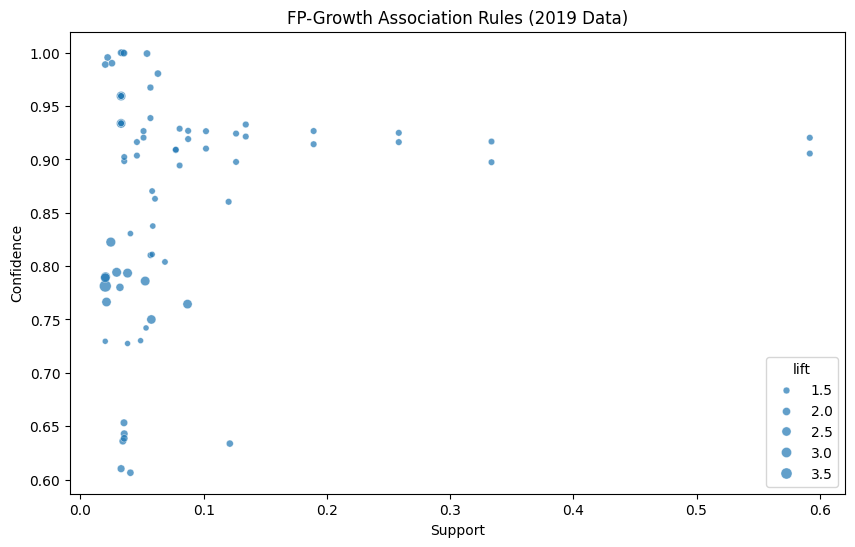

In [3]:
# --------------------------
# Step 11: Visualization
# --------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rules,
    x='support',
    y='confidence',
    size='lift',
    alpha=0.7
)
plt.title("FP-Growth Association Rules (2019 Data)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.show()


X-axis: Support

Fraction of total transactions where both antecedent and consequent appear together.

Low values (0–0.1) → most rules appear in a small fraction of lifters.

One rule is at ~0.6 support → occurs in 60% of transactions, very common.

Y-axis: Confidence

How likely the consequent occurs given the antecedent.

High values (0.7–1.0) → rules are very reliable.

Bubble size: Lift

Measures strength of association relative to chance.

Bigger bubbles → stronger association.

Lift > 1 → meaningful rules, lift >> 1 → very strong rules.

In [4]:
# --------------------------
# Step 12: Focus on elite performance (high IPFPoints)
# --------------------------
# Optional: add a flag column for high IPFPoints
high_ipf = df_2019['IPFPoints'] >= 500  # adjust threshold as needed
df_2019['HighPerformance'] = high_ipf.astype(str)

# Transactions including performance label
transactions_perf = df_2019[['Sex', 'AgeClass', 'Equipment', 'weight_bin', 'HighPerformance']].astype(str)
transactions_perf_list = transactions_perf.values.tolist()

# Encode again for FP-Growth
te_perf = TransactionEncoder()
te_perf_array = te_perf.fit(transactions_perf_list).transform(transactions_perf_list)
encoded_perf_df = pd.DataFrame(te_perf_array, columns=te_perf.columns_)

# Frequent itemsets for performance
freq_itemsets_perf = fpgrowth(encoded_perf_df, min_support=0.02, use_colnames=True)
rules_perf = association_rules(freq_itemsets_perf, metric='lift', min_threshold=1.2)
rules_perf = rules_perf[rules_perf['confidence'] >= 0.6].sort_values(by='lift', ascending=False)

print("Top 10 association rules with HighPerformance:")
print(rules_perf[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Top 10 association rules with HighPerformance:
            antecedents             consequents   support  confidence  \
266     (24-34, 90–105)                (M, Raw)  0.020130    0.781301   
685      (90–105, True)                (M, Raw)  0.037303    0.711445   
654  (120+, Single-ply)         (M, nan, False)  0.032161    0.936039   
653         (120+, nan)  (M, False, Single-ply)  0.032161    0.911014   
220      (24-34, False)                   (Raw)  0.026033    0.830562   
217      (24-34, 60–75)                   (Raw)  0.024610    0.822505   
643  (120+, nan, False)         (M, Single-ply)  0.032161    0.978568   
234          (24-34, M)                  (True)  0.056757    0.740081   
212      (24-34, 60–75)                  (True)  0.021877    0.731168   
208          (24-34, F)                   (Raw)  0.029357    0.794207   

         lift  
266  3.920978  
685  3.570405  
654  2.887226  
653  2.780673  
220  2.752011  
217  2.725315  
643  2.689339  
234  2.688507  
212  